<a href="https://colab.research.google.com/github/ME-UoP-ME421/Rankine-CB/blob/main/Simulating_Quadrotor_UAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions

* This is a group assignment. Complete the activities in groups that were assigned for ME421 for the vibrations lab.

* Make a copy of this and save it in your group github group repository.

* Do all your work, EXCLUSIVELY, in that saved notebook. Your github commits will serve as a refelection of your individual contributions. It will constitute 25% of your final grade for the lab.

* Complete Tasks#1 and Task#2 by 5:00PM on 14/06/2023

* Complete Tasks#3 and the Task#4 by 5:00PM on 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Task#5 by 5:00PM on 28/06/2023.

#References

* https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Mugas_Rigid_Body_Control.ipynb

* https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/MaithriPalaDHS_RigidBodyPIDControl_IITB_18_03_2023.pdf

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

#Task#2

Simulate the motion of a quadrotor UAV without resorting any parameterization of $SO(3)$ such as Euler angles or quaternions.

In [2]:
import numpy as np

# Quadrotor parameters
mass = 1.0  # Mass of the quadrotor (kg)
inertia = np.diag([0.02, 0.02, 0.04])  # Moment of inertia matrix (kg*m^2)
g = 9.81  # Acceleration due to gravity (m/s^2)

# Simulation parameters
dt = 0.01  # Time step (s)
total_time = 10.0  # Total simulation time (s)
num_steps = int(total_time / dt)

# Initial state
position = np.zeros(3)  # Initial position (m)
velocity = np.zeros(3)  # Initial velocity (m/s)
rotation = np.eye(3)  # Initial rotation matrix
angular_velocity = np.zeros(3)  # Initial angular velocity (rad/s)

# Simulation loop
for step in range(num_steps):
    # Forces and moments
    force = mass * (rotation @ np.array([0, 0, -g]))  # Gravity force
    moment = inertia @ angular_velocity  # Moment of inertia

    # Update linear motion
    acceleration = force / mass
    velocity += acceleration * dt
    position += velocity * dt

    # Update angular motion
    angular_acceleration = np.linalg.inv(inertia) @ (moment - np.cross(angular_velocity, inertia @ angular_velocity))
    angular_velocity += angular_acceleration * dt

    # Update rotation matrix using Rodrigues' rotation formula
    skew_symmetric = np.array([[0, -angular_velocity[2], angular_velocity[1]],
                               [angular_velocity[2], 0, -angular_velocity[0]],
                               [-angular_velocity[1], angular_velocity[0], 0]])
    rotation += (skew_symmetric @ rotation) * dt

    # Normalize rotation matrix to prevent numerical drift
    rotation, _ = np.linalg.qr(rotation)

    # Print current state
    print(f"Step {step} - Position: {position}, Rotation: {rotation}")

    # Update step
    step += dt



Step 0 - Position: [ 0.        0.       -0.000981], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 1 - Position: [ 0.        0.       -0.002943], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 2 - Position: [ 0.        0.       -0.005886], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 3 - Position: [ 0.       0.      -0.00981], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 4 - Position: [ 0.        0.       -0.014715], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 5 - Position: [ 0.        0.       -0.020601], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 6 - Position: [ 0.        0.       -0.027468], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 7 - Position: [ 0.        0.       -0.035316], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 8 - Position: [ 0.        0.       -0.044145], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 9 - Position: [ 0.        0.       -0.053955], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 10 - Pos

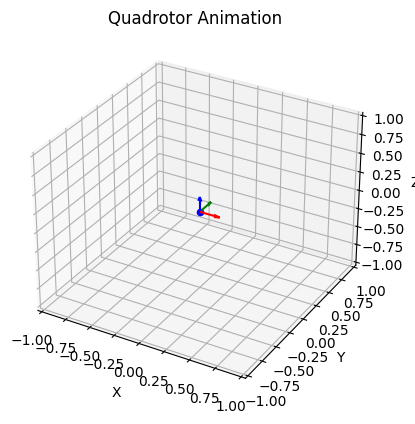

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Quadrotor parameters
mass = 1.0  # Mass of the quadrotor (kg)
inertia = np.diag([0.02, 0.02, 0.04])  # Moment of inertia matrix (kg*m^2)
g = 9.81  # Acceleration due to gravity (m/s^2)

# Simulation parameters
dt = 0.01  # Time step (s)
total_time = 10.0  # Total simulation time (s)
num_steps = int(total_time / dt)

# Initial state
position = np.zeros((num_steps, 3))  # Position (m)
velocity = np.zeros((num_steps, 3))  # Velocity (m/s)
rotation = np.zeros((num_steps, 3, 3))  # Rotation matrix

# Simulation loop
for step in range(num_steps):
    # Forces and moments
    force = mass * (rotation[step] @ np.array([0, 0, -g]))  # Gravity force
    moment = inertia @ angular_velocity  # Moment of inertia

    # Update linear motion
    acceleration = force / mass
    velocity[step] = velocity[step-1] + acceleration * dt
    position[step] = position[step-1] + velocity[step] * dt

    # Update angular motion
    angular_acceleration = np.linalg.inv(inertia) @ (moment - np.cross(angular_velocity, inertia @ angular_velocity))
    angular_velocity += angular_acceleration * dt

    # Update rotation matrix using Rodrigues' rotation formula
    skew_symmetric = np.array([[0, -angular_velocity[2], angular_velocity[1]],
                               [angular_velocity[2], 0, -angular_velocity[0]],
                               [-angular_velocity[1], angular_velocity[0], 0]])
    rotation[step] = rotation[step-1] + (skew_symmetric @ rotation[step-1]) * dt

    # Normalize rotation matrix to prevent numerical drift
    rotation[step], _ = np.linalg.qr(rotation[step])

# Animation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for step in range(num_steps):
    ax.cla()  # Clear the current plot
    ax.set_xlim([-1, 1])  # Set appropriate limits for the x-axis
    ax.set_ylim([-1, 1])  # Set appropriate limits for the y-axis
    ax.set_zlim([-1, 1])  # Set appropriate limits for the z-axis

    # Plot the quadrotor as a point at its current position
    ax.scatter(position[step, 0], position[step, 1], position[step, 2], color='b')

    # Draw the quadrotor's body axes
    scale = 0.2  # Scale factor for the body axes length
    x_axis = rotation[step] @ np.array([scale, 0, 0])
    y_axis = rotation[step] @ np.array([0, scale, 0])
    z_axis = rotation[step] @ np.array([0, 0, scale])
    ax.quiver(position[step, 0], position[step, 1], position[step, 2],
              x_axis[0], x_axis[1], x_axis[2], color='r', label='x-axis')
    ax.quiver(position[step, 0], position[step, 1], position[step, 2],
              y_axis[0], y_axis[1], y_axis[2], color='g', label='y-axis')
    ax.quiver(position[step, 0], position[step, 1], position[step, 2],
              z_axis[0], z_axis[1], z_axis[2], color='b', label='z-axis')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Quadrotor Animation')

    plt.pause(0.01)  # Pause the animation for a short time

plt.show()


#Task#3

Deerive a PID controller for the attitude control of a quadrorotor and use simulations to demibstrate the very large region of stability of the controller

Here are few example our own implementations of this controller.

* https://youtu.be/6E9WDQNVSYA
* https://youtu.be/uUKxXImRMOA
* https://youtu.be/zq05N8m_9SA
* https://youtu.be/J5dThZGZN2g
* https://youtu.be/J5MMp6Be3tU
* https://youtu.be/6ZQgE1FI6Wc

#Task#4

Derive a specialization of the controller develoed in Task#3 for the problem of stabilzing an inverted pendulum on a cart.

#Task#5

 Experimentally verify the stability properties of the controller derived in Task#5 using the experimental setup available in the applied mechanics lab.